# ML-for-Good-Hackathon submission
## Team: 6
## Team members: 

1.   Balasubramanian, Karthik
2.   Harnett, Rait
3.   Jones, Ben
4.   Kozin, Igor N
5.   Loffredo, Dom

# Overview

Our approach was to investigate well known techniques to visualize the Child Mind Institute data. We focused on the description parts on a selection of the data:

*   CrisisLogger: `Data/CrisisLogger/crisislogger.csv`
*   ProlificAcademic: `Data/ProlificAcademic/updated_data/April_21/CRISIS_Adult_April_2021.csv`, `Data/ProlificAcademic/updated_data/April_21/CRISIS_Parent_April_2021.csv`

We show how we used the following techniques:

*   Clustering documents with TFIDF and KMeans.
*   A word cloud generator.
*   BERT pre-trained model to predict sentiment.
*   Using ``spaCy`` to analyze transcriptions in the CrisisLogger data.
*   T0pp pre-trained model to predict sentiment.

# Testing usability of T0pp pretrained model

https://huggingface.co/bigscience/T0pp
https://huggingface.co/transformers/installation.html

T0* shows zero-shot task generalization on English natural language prompts, outperforming GPT-3 on many tasks, while being 16x smaller. It is a series of encoder-decoder models trained on a large set of different tasks specified in natural language prompts. We convert numerous English supervised datasets into prompts, each with multiple templates using varying formulations. These prompted datasets allow for benchmarking the ability of a model to perform completely unseen tasks specified in natural language. To obtain T0*, we fine-tune a pretrained language model on this multitask mixture covering many different NLP tasks.

The model was still too large load on a single GPU so we run it on CPU. It took under 47GB RAM and it run slower for obvious reasons but still it might be a viable option for batch processing. A single query takes a few seconds depending on the output. Our tests showed that while the model is indeed very powerful in dealing with free form texts the output needs to be carefully cross-examined and validated.

In [27]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import matplotlib.pyplot as plt
import matplotlib.cm as cm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Matplotlib is building the font cache; this may take a moment.


In [2]:
#tokenizer = AutoTokenizer.from_pretrained("bigscience/T0pp")
tokenizer = AutoTokenizer.from_pretrained("/data/data1/NLP/bigscience/T0pp", cache_dir="/data/data1/NLP")

In [3]:
#model = AutoModelForSeq2SeqLM.from_pretrained("bigscience/T0pp")
model = AutoModelForSeq2SeqLM.from_pretrained("/data/data1/NLP/bigscience/T0pp", cache_dir="/data/data1/NLP")

In [4]:
crisisLoggerDf = pd.read_csv("Data/CrisisLogger/crisislogger.csv")

/home/ink/conda3/envs/pt110cpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
# mapping of prediction values to readable sentiment values
sentiment_map = { 0:'negative', 1:'positive', 2:'unknown'}
color_map = ['#d9534f','#5bc0de','#5cb85c']
def sentiment_score(transcription):
  if (not transcription) or pd.isnull(transcription):
    return sentiment_map[2]
  input = "Is this sentiment positive or negative? " + transcription
  if len(input) > 2252:
    input = input[:2252]
  tokens =  tokenizer.encode(input, return_tensors="pt")
  output =  tokenizer.decode( model.generate(tokens)[0] )
  if sentiment_map[0] in output:
    return sentiment_map[0]
  elif sentiment_map[1] in output:
    return sentiment_map[1]
  else:
    return sentiment_map[2]

<AxesSubplot:xlabel='sentiment'>

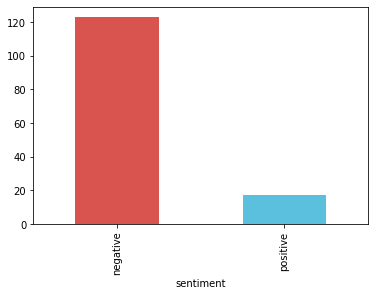

In [36]:
crisisLoggerDf['sentiment'] = crisisLoggerDf['transcriptions'].apply(lambda t: sentiment_score(t))
crisisLoggerDf.groupby('sentiment')['transcriptions'].count().plot(kind='bar',color=color_map)

In [55]:
# Sentiment value counts of descriptive columns of April_21/CRISIS_Adult_April_2021
# test on a sample  nrows=9
#
#adultApril2021Df = pd.read_csv("Data/ProlificAcademic/updated_data/April_21/CRISIS_Adult_April_2021.csv")
#parentApril2021Df = pd.read_csv("Data/ProlificAcademic/updated_data/April_21/CRISIS_Parent_April_2021.csv")

In [56]:
sample = pd.read_csv("Data/ProlificAcademic/updated_data/April_21/CRISIS_Parent_April_2021.csv", nrows=100)

In [57]:
sample.shape

(100, 339)

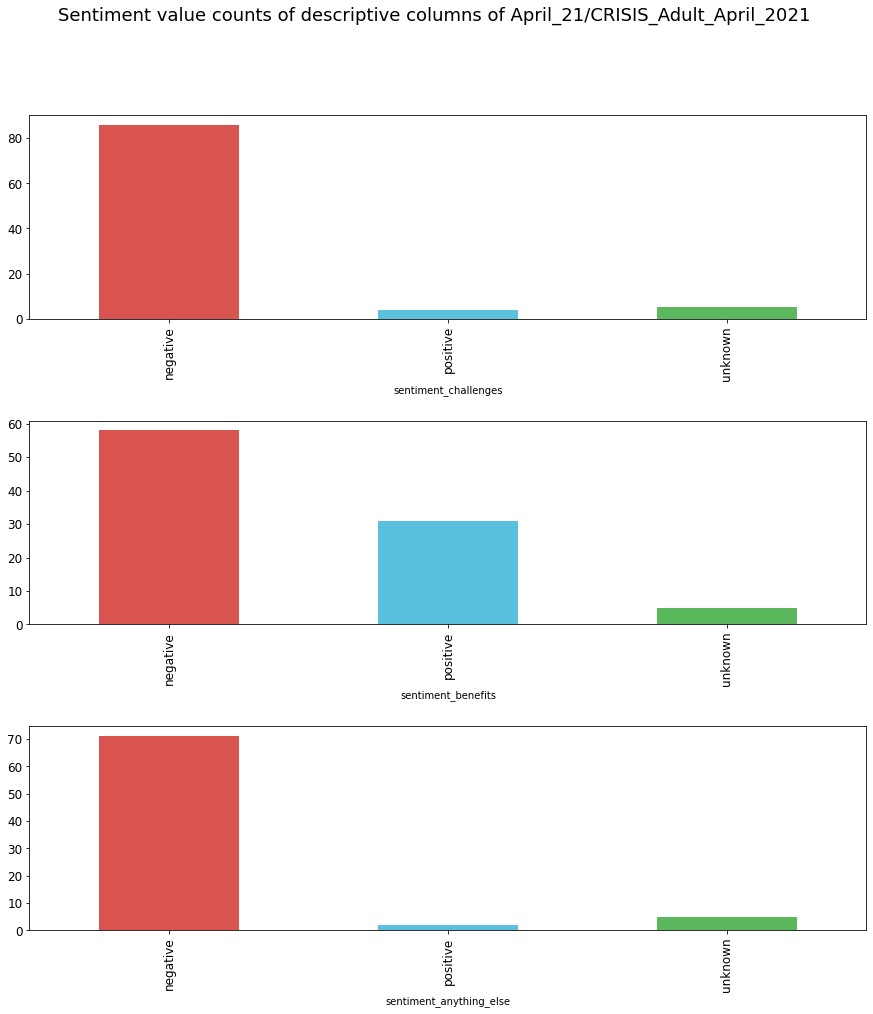

In [58]:
parentApril2021DescriptiveColumns = ['challenges', 'benefits', 'anything_else']
fig, axs = plt.subplots(nrows=len(parentApril2021DescriptiveColumns), figsize=(15,15))
fig.suptitle("Sentiment value counts of descriptive columns of April_21/CRISIS_Adult_April_2021", fontsize=18)
plt.subplots_adjust(hspace=0.50)
for index, column in enumerate(parentApril2021DescriptiveColumns):
  sentiment_column = f'sentiment_{column}'
  sample[sentiment_column] = sample[column].apply(lambda t: sentiment_score(t))
  sample.groupby(sentiment_column)[column].count().plot(kind='bar',color=color_map, ax=axs[index], xlabel=sentiment_column, fontsize=12)

In [59]:
# full data
sample = pd.read_csv("Data/ProlificAcademic/updated_data/April_21/CRISIS_Parent_April_2021.csv")

parentApril2021DescriptiveColumns = ['challenges', 'benefits', 'anything_else']
for index, column in enumerate(parentApril2021DescriptiveColumns):
  sentiment_column = f'sentiment_{column}'
  sample[sentiment_column] = sample[column].apply(lambda t: sentiment_score(t))

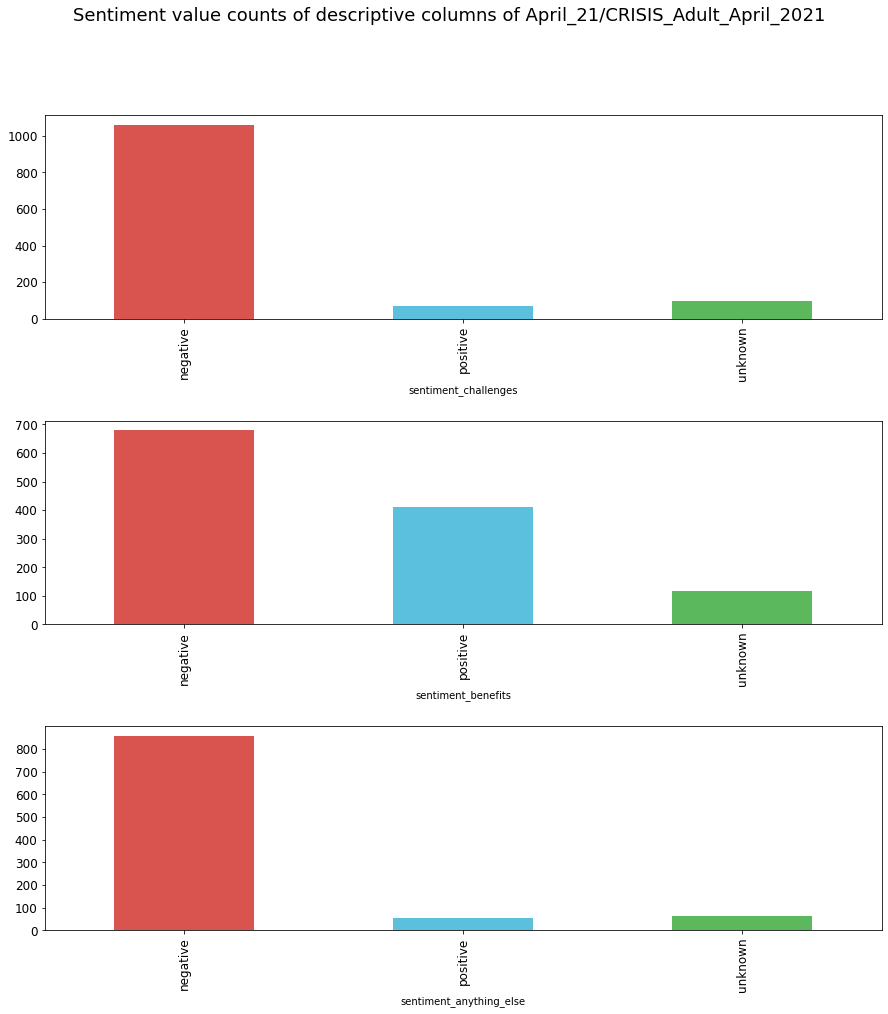

In [60]:
fig, axs = plt.subplots(nrows=len(parentApril2021DescriptiveColumns), figsize=(15,15))
fig.suptitle("Sentiment value counts of descriptive columns of April_21/CRISIS_Adult_April_2021", fontsize=18)
plt.subplots_adjust(hspace=0.50)
for index, column in enumerate(parentApril2021DescriptiveColumns):
  sentiment_column = f'sentiment_{column}'
  sample.groupby(sentiment_column)[column].count().plot(kind='bar',color=color_map, ax=axs[index], xlabel=sentiment_column, fontsize=12)